<img src="rl (1).png">

![](http://)**The steps involved in typical RL algorithm are as follows:**
1. First, the agent interacts with the environment by performing an action
2. The agent performs an action and moves from one state to another 
3. And then the agent will receive a reward based on the action it performed
4. Based on the reward, the agent will understand whether the action was good or bad
5. If the action was good, that is, if the agent received a positive reward, then the agent will prefer performing that action or else the agent will try performing an other action which results in a positive reward. So it is basically a trial and error learning process

# **Elements of RL**

# **Agent**
Agents are the software programs that make intelligent decisions and they are basically
learners in RL. Agents take action by interacting with the environment and they receive
rewards based on their actions, for example, Super Mario navigating in a video game.

# **Policy function**
A policy defines the agent's behavior in an environment. The way in which the agent
decides which action to perform depends on the policy. Say you want to reach your office
from home; there will be different routes to reach your office, and some routes are
shortcuts, while some routes are long. These routes are called policies because they
represent the way in which we choose to perform an action to reach our goal. A policy is
often denoted by the symbol 𝛑. A policy can be in the form of a lookup table or a complex
search process.

# **Value function**
A value function denotes how good it is for an agent to be in a particular state. It is
dependent on the policy and is often denoted by v(s). It is equal to the total expected
reward received by the agent starting from the initial state. There can be several value
functions; the optimal value function is the one that has the highest value for all the states
compared to other value functions. Similarly, an optimal policy is the one that has the
optimal value function.

# **Model**
Model is the agent's representation of an environment. The learning can be of two
types—model-based learning and model-free learning. In model-based learning, the agent
exploits previously learned information to accomplish a task, whereas in model-free
learning, the agent simply relies on a trial-and-error experience for performing the right
action. Say you want to reach your office from home faster. In model-based learning, you
simply use a previously learned experience (map) to reach the office faster, whereas in
model-free learning you will not use a previous experience and will try all different routes
and choose the faster one.

# Common approach with Open AI Gyms:


In [1]:
pip install gym==0.7.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym
import time
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    time.sleep(0.1)
    env.step(env.action_space.sample())

[2020-04-25 09:32:23,142] Making new env: CartPole-v0
C:\Users\Noah\anacondadesktop\lib\site-packages\gym\envs\registration.py:18: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2020-04-25 09:32:25,459] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


KeyboardInterrupt: 

<img src="cartpole.png">

In [ ]:
import gym
env = gym.make('BipedalWalker-v2')
for i_episode in range(100):
    observation = env.reset()
    for t in range(10000):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("{} timesteps taken for the episode".format(t+1))
            break

# Problem? Only custom off the shelf environments, to production usage...

This is a practical implementation of Deep Reinforcement Learning on financial datasets

In [1]:
#standard libraries for data manipulation, plotting, measuring etc...
import numpy as np
import pandas as pd
import time
import copy
import chainer
import random

First let us define the neural network that will be used in estimating the Q-function (Deep reinforcement learning)
For that we will be using [chainer](https://github.com/chainer/chainer) deep learning framework aiming at flexibility. It provides automatic differentiation APIs based on the define-by-run approach (a.k.a. dynamic computational graphs) as well as object-oriented high-level APIs to build and train neural networks.

In [2]:
import chainer.functions as funcs
import chainer.links as links

A couple of notes about architecture:

1. Activation function is ELU function as a link (activation).
2. Regarding neurons, using this approximation formula for architecture $$N_h = \frac{N_s} {(\alpha * (N_i + N_o))}$$

$N_i$ = number of input neurons.   
$N_o$ = number of output neurons.  
$N_s$ = number of samples in training data set.  
$\alpha$ = an arbitrary scaling factor usually 2-10.  


 Medium size architecture, going deeper would be to expensive

In [3]:
class NN_Q_approximator(chainer.Chain):
    
    # initialise the network
    def __init__(self, input_size, output_size=3):
        super(NN_Q_approximator, self).__init__(
            fc1 = links.Linear(input_size, 128),
            fc2 = links.Linear(128, 256),
            fc3 = links.Linear(256, 128),
            fc4 = links.Linear(128, output_size))
        
    #add the layers
    def __call__(self, x):
        h = funcs.elu(self.fc1(x))
        h = funcs.elu(self.fc2(h))
        h = funcs.elu(self.fc3(h))
        y = self.fc4(h)
        return y
    
    # Clears all gradient arrays. This method should be called before the backward computation at every iteration of the optimization.
    def reset(self):
        self.cleargrads()

Abbreviations for different stocks can be found [here.](http://eoddata.com/symbols.aspx)

In our case **Apple** is aapl.us and **Amazon** is amzn.us

In [4]:
states = pd.read_csv('aapl.us.txt')#change the path to where you have your stock data
states['Date'] = pd.to_datetime(states['Date'])
states = states.set_index('Date')


From 2014-03-27 up until 2016-06-01 we will be training, than from 2016-06-01 is the testing period and evaluation of reinforcement learning.

In [5]:
train_date1 = '2014-06-01'
train_date2 = '2016-06-01'
train_set = states[train_date1:train_date2]
test_set = states[train_date2:]


In [6]:
train_set

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2014-06-02,84.939,85.054,83.404,84.228,98405789,0
2014-06-03,84.202,85.581,84.174,85.417,78047724,0
2014-06-04,85.403,86.805,85.227,86.394,89398150,0
2014-06-05,86.578,87.002,86.097,86.733,80934610,0
2014-06-06,87.075,87.256,86.346,86.494,93342815,0
...,...,...,...,...,...,...
2016-05-25,96.092,97.134,95.547,96.998,35401739,0
2016-05-26,97.075,98.102,96.063,97.787,56007085,0
2016-05-27,96.841,97.846,96.652,97.729,35434339,0


In [7]:
import matplotlib.pyplot as plt

Plot the closing price of the train set

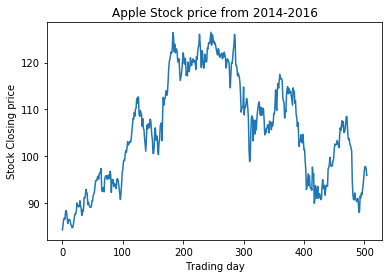

In [8]:

plt.plot(range(len(train_set)),train_set.Close)
plt.xlabel('Trading day')
plt.ylabel('Stock Closing price') 
plt.title('Apple Stock price from 2014-2016')
plt.show()

Plot the closing price of the test set

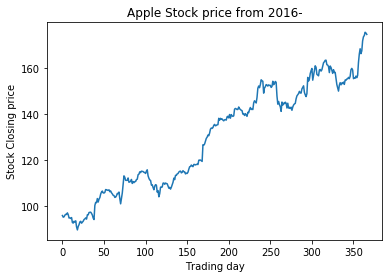

In [9]:

plt.plot(range(len(test_set)),test_set.Close)
plt.xlabel('Trading day')
plt.ylabel('Stock Closing price') 
plt.title('Apple Stock price from 2016-')
plt.show()

Now given that we do not have something like [OpenGym](https://gym.openai.com/), where there are already some premade environments where our agent can interact, we have to define our own environment in the context of our financial dataset.

Some general guidelines when defining own environment:

1. What are the states, actions and rewards in given context
2. How do we update states(positions) and rewards when we select certain action
3. How long back do we look (i.e. how many time steps in the past do we save the environment states)
$$
E=\left\{S_{0}, A_{0}, R_{0}, S_{1}, A_{1}, R_{1}, \ldots, S_{\tau-1}, A_{\tau-1}, R_{\tau-1}, S_{\tau}\right\}
$$




In [10]:
class Stock_environment:
    
    # Initialise data, time horizont=history and reset method to wipe it clean
    def __init__(self, data, history_days=90):
        self.data = data
        self.history_days = history_days
        self.reset()
        
    # Start from beggining, i.e. initialise the values again. This will happen pro training epoch 
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_days)]
        return [self.position_value] + self.history # history of position values
    
    # Define what happens when taking action, we know 3 possible actions are available: hold (0) buy (1) and sell (2)
    def step(self, act):
        reward = 0
        # if we choose to buy, than we will save the closing price (that we bought) that day
        # please note that the assumption is that when we buy, we buy "volume of one" for that day of purchasing
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        # if we do nothing, nothing changes and there is no reward (hold=1)
        elif act == 0:
        # and if we (sell=2) and there is nothing to sell we will punish it. Else we will just sum the profit from the previous positions
        elif act == 2:
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0   
                # now for everything we bought, when we sell it, we will subtract it from every positions (bought stock)
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)

                reward += profits
                self.profits += profits
                # when we sell we are emptying entire stock that we had (positions is empty list)
                self.positions = []
        
        
        # next training day (trading day)
        self.t += 1
        self.position_value = 0
        # is observation of value our position takes for all of the position that we took before
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        # drop(pop) the first day in the 120 day history (in order to have only 120 days in the history)
        self.history.pop(0)
        
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        return [self.position_value] + self.history, reward, self.done # history of position values, reward(profits), finished with training (Boolian)

# Deep Q networks:

In [ ]:
Short overview:

In [ ]:
Main goal

\begin{equation}
Q(s, a, \theta) \approx  Q^{\pi}(s, a)
\end{equation}

what is it:

\begin{equation}\label{state_value_func}
Q^{\pi}(s, a)=E_{\pi}\left[R_{t}^{\gamma} | S_{t}=s, A_{t}=a\right]=\mathbb{E}_{\pi}\left[\sum_{k=0}^{\tau-t} \gamma^{k} R_{t+k} | S_{t}=s, A_{t}=a\right]
\end{equation}

What does optimal mean?

 \begin{equation}\label{opt_func2}
Q^{*}(s, a)=\max _{\pi}{Q^{\pi}(s, a)}
\end{equation}


How do we do it?

\begin{equation}\label{update}
Q\left(s_{t}, a_{t}\right) \leftarrow Q\left(s_{t}, a_{t}\right)+\alpha_{t}\left(s_{t}, a_{t}\right)\left[r_{t}+\gamma max_{a \in A\left(s_{t+1}\right)} Q\left(s_{t+1}, a\right)-Q\left(s_{t}, a_{t}\right)\right]
\end{equation} (6.2)

In neural network approach we will try to learn this optimal policy in every training period $t$ while updating the weights $\theta$ under the minimisation of the following loss function:

\begin{equation}
\text {L}=\left(y_{i}-Q(s, a ; \theta)\right)^{2}
\end{equation}

and $y_i$ is a term in the brackets

Neural network for approximation is the 'NN_approximator' from above.


One possible objection to the approach is that in the equation (6.2) we are training always with the last environment instance. So the "experience" of the agent is only that what he saw in the previous step. Alternative to this would be to save our environment:
$$
E=\left\{S_{0}, A_{0}, R_{0}, S_{1}, A_{1}, R_{1}, \ldots, S_{\tau-1}, A_{\tau-1}, R_{\tau-1}, S_{\tau}\right\}
$$
and let the agent learn randomly from the previous n experiences. Always when performing a new step, we will disregard the oldest experience in this chain of random variables. This ensures that the states are not correlated and enough diversity is introduced.

Epsilon greedy policy of taken the next action:

\begin{equation}\label{epsilon}
\pi_{\varepsilon}(s)=\left\{\begin{array}{ll}
\text {random action taken from set } \mathcal{A}(s) & \text { if } p<\varepsilon \\
\arg \max _{a \in \mathcal{A}(s)} Q(s, a) & \text { otherwise }
\end{array}\right.
\end{equation}

In [55]:
def dqn_training(stock_environment):

    Q_function = NN_Q_approximator(input_size=stock_environment.history_days+1, output_size=3)
    # Q_max will be the neural network that approximates the Q function FOR the update part i.e. when we use the max(x,.)
    # part of the equation. Do note that here is where these different algorithms (DQN,DDQN) differ.
    Q_max = copy.deepcopy(Q_function)
    #optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q_function)

    # how many environments are we going to keep in memory, but not only that but this is influence when do we start training (when we filled the whole memory)
    environment_memory_size = 150
    # how many elements saved in the environment, will be used in training (size of the subset)
    environment_subset_amount= 20
    
    # We know that we will use the epsilon greedy policy. Having a fix policy is not optimal in every stage. Hence
    # epsilon of 1 in the beggining means more exploration and later on we do more exploitation (when we decrease the values)
    epsilon = 1.0
    #how much to decrease epsilon
    epsilon_decrease = 1e-3
    #dont reduce epsilon smaller than smallest_possible_eps (in other words not that much exploitation)
    smallest_possible_eps = 0.1
    #when to start reducing epsilon, after how many actions(steps) we took
    start_reduce_epsilon_after = 150
    show_log_freq = 5
    #how ofter to update the Q-function values
    update_frequency = 10
    # how often to update the Q_max above
    update_Q_max_frequency = 15
    # gamma is parameter is the discount factor, how important past
    gamma = 0.97
    # variable to hold the memory
    memory = []
    # variable to hold all the steps
    total_steps = 0
    # variable to hold all the rewards
    total_rewards = []
    # variable to hold all the losses
    total_losses = []

    start = time.time()
    # how many epochs (periods of training) do we execute. 100
    for epoch in range(70):
        
        #start with a fresh environment every epoch
        history_pos_value_r = stock_environment.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < (len(stock_environment.data)-1):

            # choose randomly one of our 3 possible actions, buy hold and sell. Following three lines of code will perform the
            # epsilon greedy policy, i.e. exploration and exploitation and if we are exploiting than we will take the
            # policy out of these 3 that have the maximal Q-value
            max_step = random.choice([0,1,2])
            if np.random.rand() > epsilon:
                max_step = Q_function(np.array(history_pos_value_r, dtype=np.float32).reshape(1, -1))
                max_step = np.argmax(max_step.data)

            # select an action in the environment (the one with maximal Q-value)
            history_pos_value, reward, done = stock_environment.step(max_step)

            # add enironment variables to the memory
            memory.append((history_pos_value_r, max_step, reward, history_pos_value, done))
            # drop the first one we added (last in first out principle)
            if len(memory) > environment_memory_size:
                memory.pop(0)

            # we only start training when the memory is full (so we can sample completely)
            if len(memory) == environment_memory_size:
                # update Q value every 15 steps (i.e. update_frequency)
                if total_steps % update_frequency == 0:
                    # shuffle some random environment values from memory
                    shuffled_memory = np.random.permutation(memory)
                    for j in range(len(shuffled_memory[::environment_subset_amount])):
                        environment_subset = np.array(shuffled_memory[j:j+environment_subset_amount])
                        environment_subset_history_pos_value_r = np.array(environment_subset[:, 0].tolist(), dtype=np.float32).reshape(environment_subset_amount, -1)
                        environment_subset_max_step = np.array(environment_subset[:, 1].tolist(), dtype=np.int32)
                        environment_subset_reward = np.array(environment_subset[:, 2].tolist(), dtype=np.int32)
                        environment_subset_history_pos_value = np.array(environment_subset[:, 3].tolist(), dtype=np.float32).reshape(environment_subset_amount, -1)
                        environment_subset_done = np.array(environment_subset[:, 4].tolist(), dtype=np.bool)

                        Q = Q_function(environment_subset_history_pos_value)
                        maxQ = np.max(Q_max(environment_subset_history_pos_value).data, axis=1)
                        target = copy.deepcopy(Q.data)
                        # update the Q
                        for i in range(environment_subset_amount):
                            target[i, environment_subset_max_step[i]] = environment_subset_reward[i]+gamma*maxQ[i]*(not environment_subset_done[i])
                        
                        Q_function.reset()
                        # loss function and backpropagation for neural network to learn
                        loss = funcs.mean_squared_error(Q, target)
                        total_loss += loss.data
                        # Here we learn as we are updating the weights with backpropagation, and we can make better
                        # approximation which we will again use in the greedy-epsilon decisions above
                        loss.backward()
                        optimizer.update()
                
                if total_steps % update_Q_max_frequency == 0:
                    Q_max = copy.deepcopy(Q_function)

            # start decreasing epsilon this is where we opt for more exploitation instead of exploration
            if epsilon > smallest_possible_eps and total_steps > start_reduce_epsilon_after:
                epsilon -= epsilon_decrease

            # next step, increase the rewards and steps, history of positional value
            total_reward += reward
            history_pos_value_r = history_pos_value
            step += 1
            total_steps += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

    return total_rewards
    

In [12]:
total_rewards = dqn_training(Stock_environment(train_set))

For 50 training periods, we see that we are converging and learning to trade beter and better.

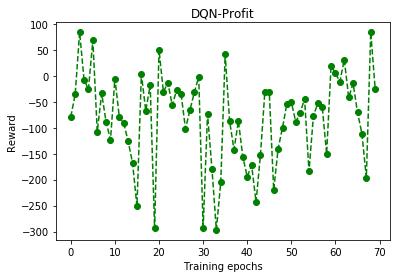

In [13]:

plt.plot(range(70), total_rewards, marker='o', linestyle='--', color='g', label='Square') 
plt.xlabel('Training epochs')
plt.ylabel('Reward') 
plt.title('DQN-Profit')
plt.show()

Whats the difference of DQN to Double DQN?

In the beginning agent wont know nothing about environment and will only be learning and not exploiting. Such Q-values have lots of noises that will propagate from the beginning into the feature and there will always be the possibility that action with maximum estimated Q-value is not really the best one. In other words agent will tend to take the non-optimal action in any given state only because it has the maximum Q-value. Such problem is called the overestimation of Q-value. This problem is not specific to Deep Q-Networks but also occurs for the standard Q-learning. To solve the problem of overestimation of Q-value, we introduce two functions $Q^{A}$ and $Q^{B}.$ Each of them is learning
independently. One of the Q function will be used to select an action and the other Q function is used
to evaluate an action

\begin{equation}\label{loss}
\text {L}=\left(y_{i}-Q(s, a ; \theta)\right)^{2}
\end{equation}

$y_{i}=r+\gamma Q \left(s,argmax Q \left(s,a;\theta^{-}\right)\right); \theta^{+})$

In [14]:
def ddqn_training(stock_environment):

    Q_function = NN_Q_approximator(input_size=stock_environment.history_days+1, output_size=3)
    # Q_max will be the neural network that approximates the Q function FOR the update part i.e. when we use the max(x,.)
    # part of the equation. Do note that here is where these different algorithms (DQN,DDQN) differ.
    Q_max = copy.deepcopy(Q_function)
    #optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q_function)

    # how many environments are we going to keep in memory, but not only that but this is influence when do we start training (when we filled the whole memory)
    environment_memory_size = 150
    # how many elements saved in the environment, will be used in training (size of the subset)
    environment_subset_amount= 20
    
    # We know that we will use the epsilon greedy policy. Having a fix policy is not optimal in every stage. Hence
    # epsilon of 1 in the beggining means more exploration and later on we do more explotation (when we decrease the values)
    epsilon = 1.0
    #how much to decrease epsilon
    epsilon_decrease = 1e-3
    #dont reduce epsilon smaller than smallest_possible_eps (in other words not that much exploitation)
    smallest_possible_eps = 0.1
    #when to start reducing epsilon, after how many actions(steps) we took
    start_reduce_epsilon_after = 150
    show_log_freq = 5
    #how ofter to update the Q-function values
    update_frequency = 10
    # how often to update the Q_max above
    update_Q_max_frequency = 15
    # gamma is parameter is the discount factor, how important past
    gamma = 0.97
    # variable to hold the memory
    memory = []
    # variable to hold all the steps
    total_steps = 0
    # variable to hold all the rewards
    total_rewards = []
    # variable to hold all the losses
    total_losses = []

    start = time.time()
    # how many epochs (periods of training) do we execute. 100
    for epoch in range(70):
        
        #start with a fresh environment every epoch
        history_pos_value_r = stock_environment.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < (len(stock_environment.data)-1):

            # choose randomly one of our 3 possible actions, buy hold and sell. Following three lines of code will perform the
            # epsilon greedy policy, i.e. exploration and exploitation and if we are exploiting than we will take the
            # policy out of these 3 that have the maximal Q-value
            max_step = random.choice([0,1,2])
            if np.random.rand() > epsilon:
                max_step = Q_function(np.array(history_pos_value_r, dtype=np.float32).reshape(1, -1))
                max_step = np.argmax(max_step.data)

            # select an action in the environment (the one with maximal Q-value)
            history_pos_value, reward, done = stock_environment.step(max_step)

            # add enironment variables to the memory
            memory.append((history_pos_value_r, max_step, reward, history_pos_value, done))
            # drop the first one we added (last in first out principle)
            if len(memory) > environment_memory_size:
                memory.pop(0)

            # we only start training when the memory is full (so we can sample completely)
            if len(memory) == environment_memory_size:
                # update Q value every 15 steps (i.e. update_frequency)
                if total_steps % update_frequency == 0:
                    # shuffle some random environment values from memory
                    shuffled_memory = np.random.permutation(memory)
                    for j in range(len(shuffled_memory[::environment_subset_amount])):
                        environment_subset = np.array(shuffled_memory[j:j+environment_subset_amount])
                        environment_subset_history_pos_value_r = np.array(environment_subset[:, 0].tolist(), dtype=np.float32).reshape(environment_subset_amount, -1)
                        environment_subset_max_step = np.array(environment_subset[:, 1].tolist(), dtype=np.int32)
                        environment_subset_reward = np.array(environment_subset[:, 2].tolist(), dtype=np.int32)
                        environment_subset_history_pos_value = np.array(environment_subset[:, 3].tolist(), dtype=np.float32).reshape(environment_subset_amount, -1)
                        environment_subset_done = np.array(environment_subset[:, 4].tolist(), dtype=np.bool)

                        # NOTE that here is the essential difference between DQN and DDQN:
                        
#                         Q = Q_function(environment_subset_history_pos_value)
#                         maxQ = np.max(Q_max(environment_subset_history_pos_value).data, axis=1)
#                         target = copy.deepcopy(Q.data)
#                         # update the Q
#                         for i in range(environment_subset_amount):
#                             target[i, environment_subset_max_step[i]] = environment_subset_reward[i]+gamma*maxQ[i]*(not environment_subset_done[i])
                        
                        
                        
                        Q = Q_function(environment_subset_history_pos_value)
                        indices = np.argmax(Q.data, axis=1)
                        maxQ_delta = Q_max(environment_subset_history_pos_value).data
                        target = copy.deepcopy(Q.data)
                        # update the Q
                        for i in range(environment_subset_amount):
                            target[i, environment_subset_max_step[i]] = environment_subset_reward[i]+gamma*maxQ_delta[i, indices[i]]*(not environment_subset_done[i])
                        
                        Q_function.reset()
                        # loss function and backpropagation for neural network to learn
                        loss = funcs.mean_squared_error(Q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()
                
                if total_steps % update_Q_max_frequency == 0:
                    Q_max = copy.deepcopy(Q_function)

            # start decreasing epsilon this is where we opt for more exploitation instead of exploration
            if epsilon > smallest_possible_eps and total_steps > start_reduce_epsilon_after:
                epsilon -= epsilon_decrease

            # next step, increase the rewards and steps, history of positional value
            total_reward += reward
            history_pos_value_r = history_pos_value
            step += 1
            total_steps += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

    return total_rewards
    

In [15]:
total_rewards = ddqn_training(Stock_environment(train_set))

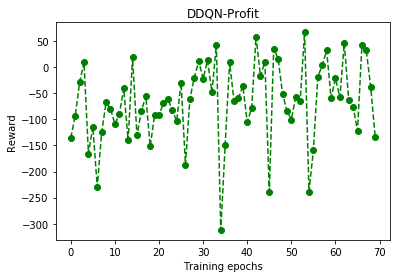

In [16]:

plt.plot(range(70), total_rewards, marker='o', linestyle='--', color='g', label='Square') 
plt.xlabel('Training epochs')
plt.ylabel('Reward') 
plt.title('DDQN-Profit')
plt.show()

Finally Dueling Double Deep Q-learning

Here we will additionally to the DDQ have changes to the neural network that learns

The architecture of dueling DQN is essentially the same as DQN, except that the fully connected layer at the end is divided into two streams. One stream computes the value function, and the other stream computes the advantage function. Finally, we combine these two streams using the aggregate layer and get the Q function. 

When constructing this neural network for the DDQN following picture of seperating the fully connected layer (last layer) should be kept in mind 

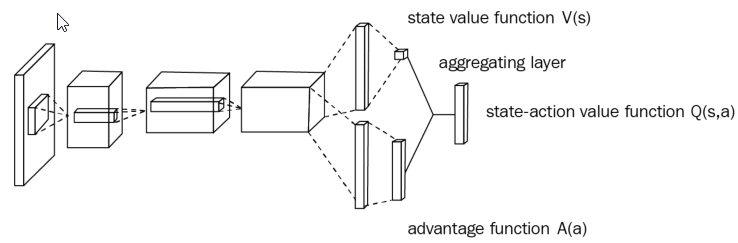

We need additional network, for the dueling double DQN

In [17]:
#neural network value and advantage function approximator
class NN_V_A_approximator(chainer.Chain):

        def __init__(self, input_size, output_size):
            super(NN_V_A_approximator, self).__init__(
                fc1 = links.Linear(input_size, 128),
                fc2 = links.Linear(128, 256),
                fc3 = links.Linear(256, 256//2),
                fc4 = links.Linear(256, 256//2),
                state_value = links.Linear(256//2, 1),
                advantage_value = links.Linear(256//2, output_size)
            )
            self.input_size = input_size
            self.output_size = output_size

        def __call__(self, x):
            h = funcs.elu(self.fc1(x))
            h = funcs.elu(self.fc2(h))
            hs = funcs.elu(self.fc3(h))
            ha = funcs.elu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (funcs.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = funcs.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - funcs.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.cleargrads()

In [18]:
def dddqn_training(stock_environment):

    Q_function = NN_V_A_approximator(input_size=stock_environment.history_days+1, output_size=3)
    # Q_max will be the neural network that approximates the Q function FOR the update part i.e. when we use the max(x,.)
    # part of the equation. Do note that here is where these different algorithms (DQN,DDQN) differ.
    Q_max = copy.deepcopy(Q_function)
    #optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q_function)

    # how many environments are we going to keep in memory, but not only that but this is influence when do we start training (when we filled the whole memory)
    environment_memory_size = 150
    # how many elements saved in the environment, will be used in training (size of the subset)
    environment_subset_amount= 20
    
    # We know that we will use the epsilon greedy policy. Having a fix policy is not optimal in every stage. Hence
    # epsilon of 1 in the beggining means more exploration and later on we do more explotation (when we decrease the values)
    epsilon = 1.0
    #how much to decrease epsilon
    epsilon_decrease = 1e-3
    #dont reduce epsilon smaller than smallest_possible_eps (in other words not that much exploitation)
    smallest_possible_eps = 0.1
    #when to start reducing epsilon, after how many actions(steps) we took
    start_reduce_epsilon_after = 150
    show_log_freq = 5
    #how ofter to update the Q-function values
    update_frequency = 10
    # how often to update the Q_max above
    update_Q_max_frequency = 15
    # gamma is parameter is the discount factor, how important past
    gamma = 0.97
    # variable to hold the memory
    memory = []
    # variable to hold all the steps
    total_steps = 0
    # variable to hold all the rewards
    total_rewards = []
    # variable to hold all the losses
    total_losses = []

    start = time.time()
    # how many epochs (periods of training) do we execute. 100
    for epoch in range(70):
        
        #start with a fresh environment every epoch
        history_pos_value_r = stock_environment.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < (len(stock_environment.data)-1):

            # choose randomly one of our 3 possible actions, buy hold and sell. Following three lines of code will perform the
            # epsilon greedy policy, i.e. exploration and exploitation and if we are exploiting than we will take the
            # policy out of these 3 that have the maximal Q-value
            max_step = random.choice([0,1,2])
            if np.random.rand() > epsilon:
                max_step = Q_function(np.array(history_pos_value_r, dtype=np.float32).reshape(1, -1))
                max_step = np.argmax(max_step.data)

            # select an action in the environment (the one with maximal Q-value)
            history_pos_value, reward, done = stock_environment.step(max_step)

            # add enironment variables to the memory
            memory.append((history_pos_value_r, max_step, reward, history_pos_value, done))
            # drop the first one we added (last in first out principle)
            if len(memory) > environment_memory_size:
                memory.pop(0)

            # we only start training when the memory is full (so we can sample completely)
            if len(memory) == environment_memory_size:
                # update Q value every 15 steps (i.e. update_frequency)
                if total_steps % update_frequency == 0:
                    # shuffle some random environment values from memory
                    shuffled_memory = np.random.permutation(memory)
                    for j in range(len(shuffled_memory[::environment_subset_amount])):
                        environment_subset = np.array(shuffled_memory[j:j+environment_subset_amount])
                        environment_subset_history_pos_value_r = np.array(environment_subset[:, 0].tolist(), dtype=np.float32).reshape(environment_subset_amount, -1)
                        environment_subset_max_step = np.array(environment_subset[:, 1].tolist(), dtype=np.int32)
                        environment_subset_reward = np.array(environment_subset[:, 2].tolist(), dtype=np.int32)
                        environment_subset_history_pos_value = np.array(environment_subset[:, 3].tolist(), dtype=np.float32).reshape(environment_subset_amount, -1)
                        environment_subset_done = np.array(environment_subset[:, 4].tolist(), dtype=np.bool)

                        # NOTE that here is the essential difference between DQN and DDQN:
                        Q = Q_function(environment_subset_history_pos_value)
                        indices = np.argmax(Q.data, axis=1)
                        maxQ_delta = Q_max(environment_subset_history_pos_value).data

                        target = copy.deepcopy(Q.data)
                        # update the Q
                        for i in range(environment_subset_amount):
                            target[i, environment_subset_max_step[i]] = environment_subset_reward[i]+gamma*maxQ_delta[i, indices[i]]*(not environment_subset_done[i])
                        
                        Q_function.reset()
                        # loss function and backpropagation for neural network to learn
                        loss = funcs.mean_squared_error(Q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()
                
                if total_steps % update_Q_max_frequency == 0:
                    Q_max = copy.deepcopy(Q_function)

            # start decreasing epsilon this is where we opt for more exploitation instead of exploration
            if epsilon > smallest_possible_eps and total_steps > start_reduce_epsilon_after:
                epsilon -= epsilon_decrease

            # next step, increase the rewards and steps, history of positional value
            total_reward += reward
            history_pos_value_r = history_pos_value
            step += 1
            total_steps += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

    return total_rewards
    

In [19]:
total_rewards = dddqn_training(Stock_environment(train_set))

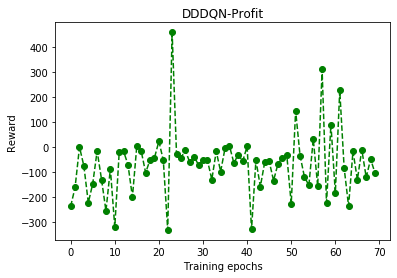

In [20]:

plt.plot(range(70), total_rewards, marker='o', linestyle='--', color='g', label='Square') 
plt.xlabel('Training epochs')
plt.ylabel('Reward') 
plt.title('DDDQN-Profit')
plt.show()

# Now the interesting question, can we abstract it away and build a library?

in other words can we create a python library for stock trading where user will choose a stock and a RL algorithm, data will be fetched from a website and agent will be trained. Plot of profits will be returned.

### Web scraping (beautiful soup, selenium etc)

no need to repeat what great free tutorials already mentioned.

https://www.mattbutton.com/2019/01/24/how-to-scrape-yahoo-finance-and-extract-fundamental-stock-market-data-using-python-lxml-and-pandas/

Only shortly:

In [21]:
import time
import urllib
# Build the cookie handler
cookier = urllib.request.HTTPCookieProcessor()
opener = urllib.request.build_opener(cookier)
urllib.request.install_opener(opener)

# Cookie and corresponding crumb
_cookie = None
_crumb = None

# Headers to fake a user agent
_headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.101 Safari/537.36'
}


def _get_cookie_crumb():
    '''
    This function perform a query and extract the matching cookie and crumb.
    '''
    global cookier, _cookie, _crumb

    # Perform a Yahoo financial lookup on SP500
    cookier.cookiejar.clear()
    req = urllib.request.Request(
        'https://finance.yahoo.com/quote/^GSPC', headers=_headers)
    f = urllib.request.urlopen(req, timeout=5)
    alines = f.read().decode('utf-8')

    # Extract the crumb from the response
    cs = alines.find('CrumbStore')
    cr = alines.find('crumb', cs + 10)
    cl = alines.find(':', cr + 5)
    q1 = alines.find('"', cl + 1)
    q2 = alines.find('"', q1 + 1)
    crumb = alines[q1 + 1:q2]
    _crumb = crumb

    # Extract the cookie from cookiejar
    for c in cookier.cookiejar:
        if c.domain != '.yahoo.com':
            continue
        if c.name != 'B':
            continue
        _cookie = c.value

    # Print the cookie and crumb
    #print('Cookie:', _cookie)
    #print('Crumb:', _crumb)


def load_yahoo_quote(ticker, begindate, enddate, info='quote'):
    '''
    This function load the corresponding history/divident/split from Yahoo.
    The "begindate" and "enddate" are in the format of YYYYMMDD.
    The "info" can be "quote" for price, "divident" for divident events,
    or "split" for split events.
    '''
    # Check to make sure that the cookie and crumb has been loaded
    global _cookie, _crumb
    if _cookie == None or _crumb == None:
        _get_cookie_crumb()

    # Prepare the parameters and the URL
    tb = time.mktime((int(begindate[0:4]), int(
        begindate[4:6]), int(begindate[6:8]), 4, 0, 0, 0, 0, 0))
    te = time.mktime((int(enddate[0:4]), int(
        enddate[4:6]), int(enddate[6:8]), 18, 0, 0, 0, 0, 0))

    param = dict()
    param['period1'] = int(tb)
    param['period2'] = int(te)
    param['interval'] = '1d'
    if info == 'quote':
        param['events'] = 'history'
    elif info == 'dividend':
        param['events'] = 'div'
    elif info == 'split':
        param['events'] = 'split'
    param['crumb'] = _crumb
    params = urllib.parse.urlencode(param)
    url = 'https://query1.finance.yahoo.com/v7/finance/download/{}?{}'.format(
        ticker, params)
    # print(url)
    req = urllib.request.Request(url, headers=_headers)

    # Perform the query
    # There is no need to enter the cookie here, as it is automatically handled by opener
    f = urllib.request.urlopen(req, timeout=5)
    alines = f.read().decode('utf-8')
    # print(alines)
    return alines.split('\n')

In [22]:
load_yahoo_quote('GOOG', '20170722', '20180725')[0].split(",")

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [23]:
all_data=[]
for data in load_yahoo_quote('GOOG', '20170722', '20180725')[1:]:
    all_data.append(data.split(","))

In [24]:
all_data

[['2017-07-24',
  '972.219971',
  '986.200012',
  '970.770020',
  '980.340027',
  '980.340027',
  '3248300'],
 ['2017-07-25',
  '953.809998',
  '959.700012',
  '945.400024',
  '950.700012',
  '950.700012',
  '4661000'],
 ['2017-07-26',
  '954.679993',
  '955.000000',
  '942.278992',
  '947.799988',
  '947.799988',
  '2088300'],
 ['2017-07-27',
  '951.780029',
  '951.780029',
  '920.000000',
  '934.090027',
  '934.090027',
  '3213000'],
 ['2017-07-28',
  '929.400024',
  '943.830017',
  '927.500000',
  '941.530029',
  '941.530029',
  '1846400'],
 ['2017-07-31',
  '941.890015',
  '943.590027',
  '926.039978',
  '930.500000',
  '930.500000',
  '1970100'],
 ['2017-08-01',
  '932.380005',
  '937.447021',
  '929.260010',
  '930.830017',
  '930.830017',
  '1277700'],
 ['2017-08-02',
  '928.609985',
  '932.599976',
  '916.679993',
  '930.390015',
  '930.390015',
  '1824400'],
 ['2017-08-03',
  '930.340027',
  '932.239990',
  '922.239990',
  '923.650024',
  '923.650024',
  '1202500'],
 ['2017-08

In [25]:
google_df=pd.DataFrame(all_data,columns=load_yahoo_quote('GOOG', '20170722', '20180725')[0].split(","))

In [26]:
google_df=google_df.set_index('Date')

In [27]:
google_df=google_df.astype('float32')

In [56]:
google_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-07-24,972.219971,986.200012,970.770020,980.340027,980.340027,3248300.0
2017-07-25,953.809998,959.700012,945.400024,950.700012,950.700012,4661000.0
2017-07-26,954.679993,955.000000,942.278992,947.799988,947.799988,2088300.0
2017-07-27,951.780029,951.780029,920.000000,934.090027,934.090027,3213000.0
2017-07-28,929.400024,943.830017,927.500000,941.530029,941.530029,1846400.0
...,...,...,...,...,...,...
2018-07-19,1191.000000,1200.000000,1183.319946,1186.959961,1186.959961,1276700.0
2018-07-20,1186.959961,1196.859985,1184.219971,1184.910034,1184.910034,1247400.0
2018-07-23,1181.010010,1206.489990,1181.000000,1205.500000,1205.500000,2619200.0


In [28]:
total_rewards = dqn_training(Stock_environment(google_df))


Main points are: 

1. Set a stock ticker
2. Choose and RL algorithm
3. Render the result

In [29]:
pip install random

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random


In [30]:
pip install automated-stock-rl==18.0

Note: you may need to restart the kernel to use updated packages.


In [31]:
import automated_stock_rl

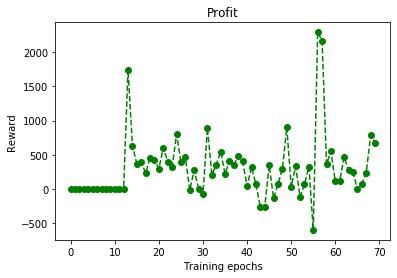

In [32]:
stock_ticker='GOOG'
RL_algorithm='DQN'

#Trading
automated_stock_rl.trade(algorithm=RL_algorithm, stock=stock_ticker)



# How to now make an viable Web App from this VERY fast:

In other words we want to serve our user and let him have a nice interface to use this stock trading agent.

In [33]:
pip install anvil-uplink

  Created wheel for ws4py: filename=ws4py-0.3.4-py3-none-any.whl size=41813 sha256=22ed0c7f90948be7704b475f1a5b2e679ce14cd9779c61be8d99d7622efce167
  Stored in directory: c:\users\noah\appdata\local\pip\cache\wheels\8d\12\ca\55a33ae5e1e153862b1e8b6d580bfc75a1adf55cab8917a76b
Successfully built ws4py
Note: you may need to restart the kernel to use updated packages.


In [53]:

import anvil.server

anvil.server.connect("Connect Hash")


In [51]:
@anvil.server.callable
def dqn_training(stock_ticker, RL_algorithm):
    
    return(sum(automated_stock_rl.trade(algorithm=RL_algorithm, stock=stock_ticker)))

# Further potential ideas:

1. Serve it via more complex Web App. This is is even easier when we abstracted the code away. Look at my other course on how to create MVP
2. Any personalised (hier stock ticker) time series that requires decision based on this time series. (Health applications-genome, medicine, text etc...)